In [23]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
import itertools

%matplotlib inline

In [19]:
ls

AlamedaCensusTracts/       Shapefile imports.ipynb
Based on datapoints.ipynb  ZillowNeighborhoods-CA/
EDF_data.csv               edf_mapping.ipynb
EDF_output.csv


In [22]:
neighborhoods = gpd.read_file("ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp")

ModuleNotFoundError: No module named 'boto3'

In [10]:
oakland_neighborhoods = neighborhoods[neighborhoods.City == "Oakland"]

NameError: name 'ls' is not defined

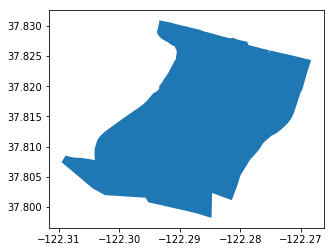

In [28]:
west = ['Clawson', 'Prescott', 'McClymonds', 'Hoover-Foster', 'Ralph Bunche', 
        'Oak Center', 'Acorn', 'Acorn Industrial', 'South Prescott']

downtown = ['Pill Hill', 'Oakland Ave-Harrison St', 'Northgate', 'Lakeside', 'Civic Center', 'Lakewide', 'Waverly',
           'Old City', 'Chinatown', 'Downtown', 'San Pablo Gateway', 'Produce & Waterfront', 'Peralta-Laney']

east = ['Columbia Gardens', 'Brookfield Village']

west_downtown = west + downtown
training_neighborhoods = oakland_neighborhoods[oakland_neighborhoods['Name'].isin(west)]
training_zone = training_neighborhoods.dissolve(by='City', aggfunc='sum')
training_bounds = training_zone.geometry.bounds
training_zone.plot()

In [12]:
def create_latlon_grid(north, south, east, west):
    step = 0.0003 #close to 33.3 m spacing in lat and long (+/- 10m in Bay Area)
    lat_steps = int((north - south)/step)
    long_steps = int((east - west)/step)
    
    lats = np.linspace(south, north, num=lat_steps)
    longs = np.linspace(east, west, num=long_steps)
    
    LatLong_list = list(itertools.product(longs, lats))
    geometry = [Point(xy) for xy in zip(LatLong_list)] #shapely point
    
    gdf = gpd.GeoDataFrame(LatLong_list, geometry=geometry, columns = ['Long', 'Lat'])
    
    return(gdf)

/Users/samchamberlain/anaconda3/envs/OSMNX/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


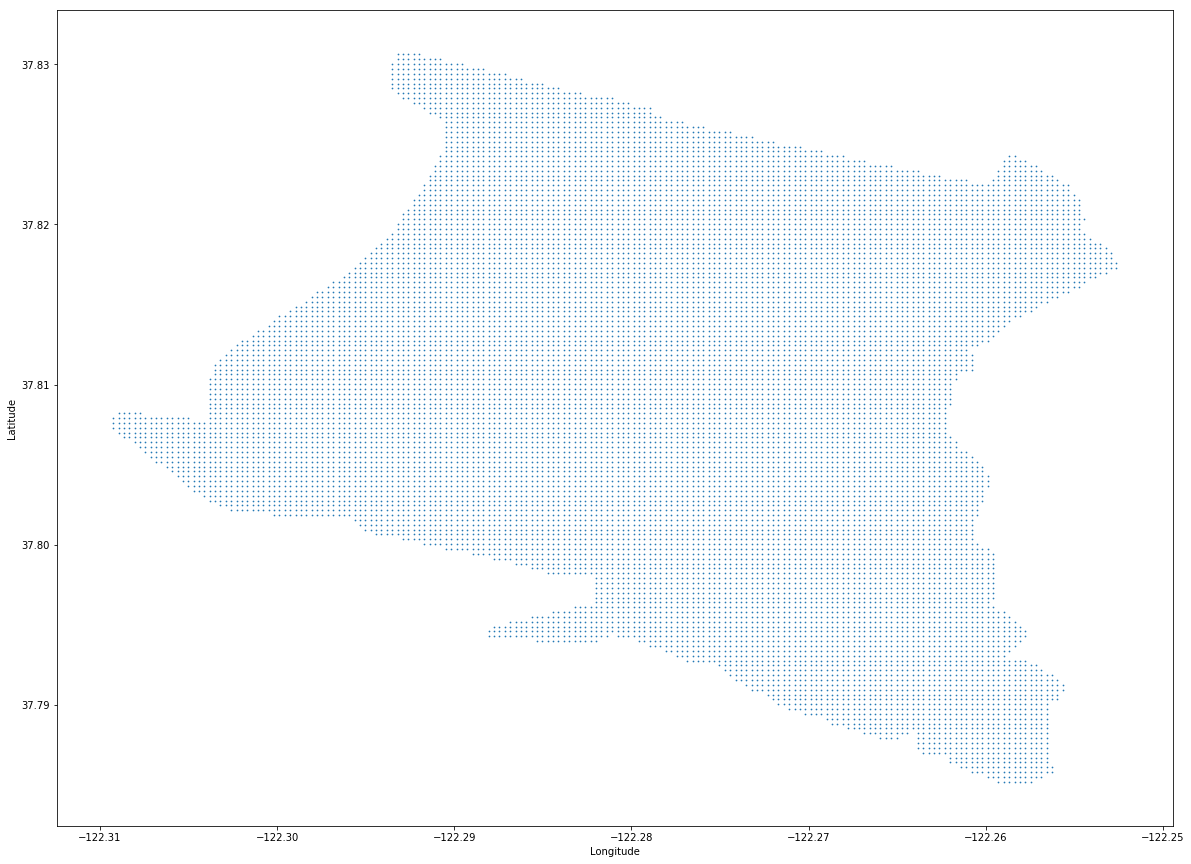

In [232]:
#create regular spatial grid in West/Downtown Oakland
total_grid = create_latlon_grid(training_bounds.maxy, training_bounds.miny, 
                                   training_bounds.maxx, training_bounds.minx)

#spatial join to within Oakland
training_grid = gpd.sjoin(total_grid, training_zone, how="inner", op="intersects")

plt.figure(figsize=(20, 15))
plt.scatter(training_grid.Long, training_grid.Lat, s=0.5)
plt.ylabel('Latitude'); plt.xlabel('Longitude');

In [225]:
training_grid.iloc[:, 0:3].head()

,Long,Lat,geometry
391,-122.252526,37.817251,POINT (-122.2525256029368 37.81725142989089)
392,-122.252526,37.817452,POINT (-122.2525256029368 37.81745245287779)
621,-122.252726,37.817251,POINT (-122.2527264158736 37.81725142989089)
622,-122.252726,37.817452,POINT (-122.2527264158736 37.81745245287779)
623,-122.252726,37.817653,POINT (-122.2527264158736 37.81765347586469)


In [14]:
#Import GSV data, create shapely points, and convert to geopandas dataframe
GSV_df = pd.read_csv('EDF_data.csv', skiprows=1)
GSV_df.head()

geometry = [Point(xy) for xy in zip(GSV_df.Longitude, GSV_df.Latitude)]
#df = df.drop(['Lon', 'Lat'], axis=1)
#crs = {'init': 'epsg:4326'}
GSV_gdf = gpd.GeoDataFrame(GSV_df, geometry=geometry)
GSV_gdf.head()

,Longitude,Latitude,NO Value,NO2 Value,BC Value,geometry
0,-122.322594,37.806781,23.390071,17.539762,0.818032,POINT (-122.3225938 37.80678062)
1,-122.322310,37.806150,19.700000,19.956750,0.551475,POINT (-122.32231 37.80614989)
2,-122.322301,37.806420,23.611111,23.967768,0.593712,POINT (-122.3223008 37.80642014)
3,-122.322299,37.805880,15.714285,18.435184,0.489898,POINT (-122.3222988 37.80587979999999)
4,-122.322267,37.806689,27.108695,25.797037,0.739341,POINT (-122.3222671 37.80668898)


/Users/samchamberlain/anaconda3/envs/OSMNX/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


<Figure size 1440x1440 with 0 Axes>

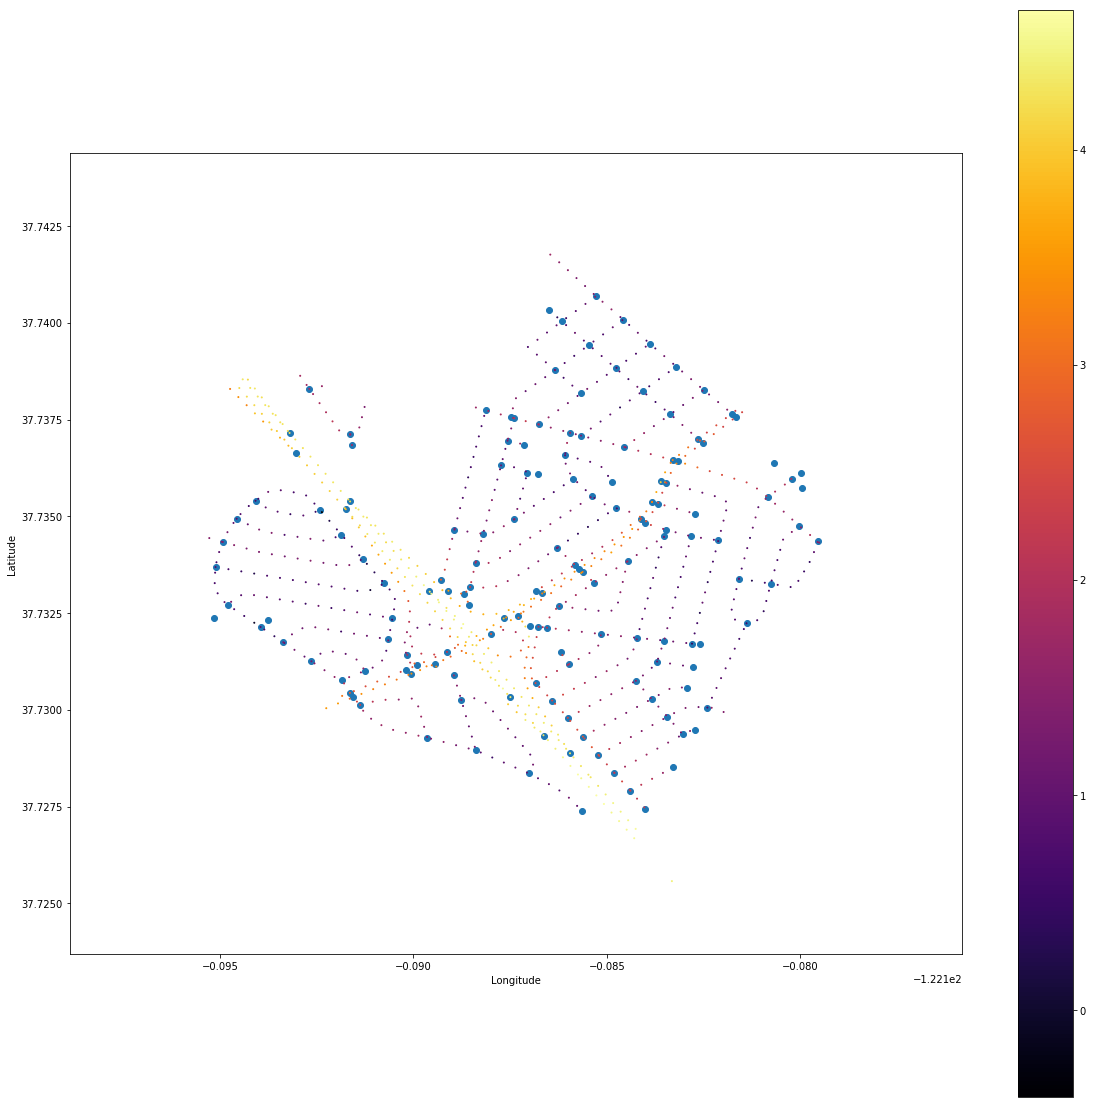

In [27]:
#subset GSV data in training grid
EDF_points = gpd.sjoin(GSV_gdf, training_zone, how="inner", op="intersects")
nodes_west = gpd.sjoin(nodes, training_zone, how="inner", op="intersects")

plt.figure(figsize=(20, 20))
nodes_west.plot(figsize=(20, 20))
plt.scatter(EDF_points.Longitude, EDF_points.Latitude, s=1, c=np.log(EDF_points['NO Value']), cmap='inferno')
plt.colorbar()
plt.ylabel('Latitude'); plt.xlabel('Longitude');

In [16]:
EDF_points

,Longitude,Latitude,NO Value,NO2 Value,BC Value,geometry,index_right,State,County,Name,RegionID
188,-122.308696,37.808334,51.600000,40.506001,2.196429,POINT (-122.3086955 37.80833449999999),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
189,-122.308661,37.808432,54.600002,41.208000,2.615312,POINT (-122.3086612 37.80843181),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
194,-122.308366,37.808265,53.226153,45.922105,2.913007,POINT (-122.308366 37.80826533),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
195,-122.308341,37.808260,54.836362,35.262219,2.201368,POINT (-122.308341 37.80826007),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
196,-122.308333,37.808359,58.499998,41.419998,2.369920,POINT (-122.3083332 37.80835856),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
200,-122.308195,37.808329,48.500001,41.758910,2.166931,POINT (-122.3081954 37.80832872),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
204,-122.308013,37.808188,48.635134,39.946667,2.137786,POINT (-122.3080126 37.80818774),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
208,-122.307867,37.808257,43.199998,38.776307,2.071008,POINT (-122.3078667 37.80825749),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
211,-122.307684,37.808115,46.153847,40.029999,2.364894,POINT (-122.3076842 37.80811541),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...
215,-122.307536,37.808194,49.235293,39.719082,2.166162,POINT (-122.3075357 37.80819372),Oakland,CACACACACACACACACACACACACACACACACACACACACA,AlamedaAlamedaAlamedaAlamedaAlamedaAlamedaAlam...,ChinatownCivic CenterOak CenterPill HillSouth ...,1142922680732683582684072684922680772681152684...


In [246]:
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x, y, xi, yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / (dist**2)

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

In [247]:
training_grid = training_grid.iloc[:, 0:3]
training_grid['NO_impute'] = simple_idw(EDF_points.Longitude, EDF_points.Latitude, EDF_points['NO Value'], 
           training_grid.Long, training_grid.Lat)

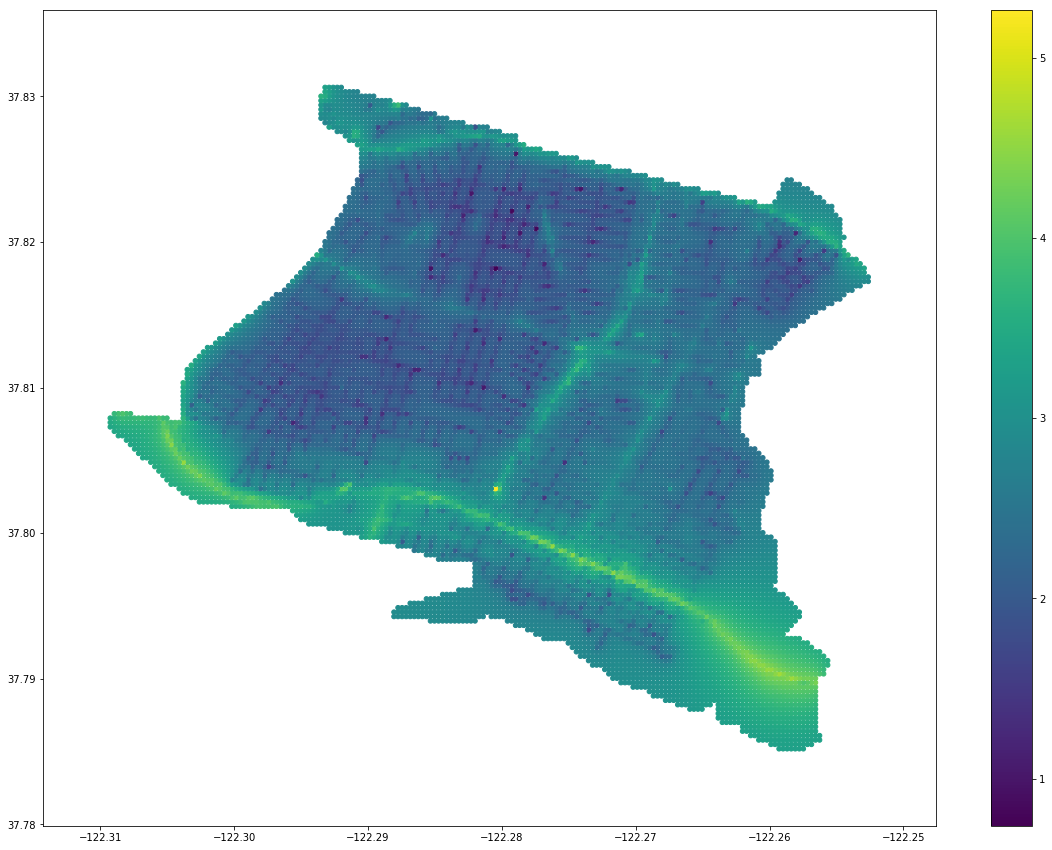

In [349]:
plt.figure(figsize=(20, 15))
plt.scatter(training_grid.Long, training_grid.Lat, c = np.log(training_grid['NO_impute']), s=20)
plt.colorbar();

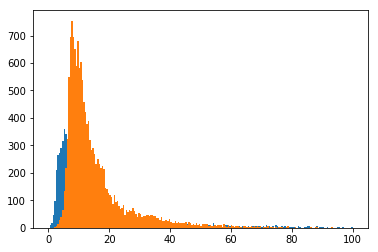

In [264]:
plt.hist(EDF_points['NO Value'], bins=200, range=(0,100));
plt.hist(training_grid['NO_impute'], bins=200, range=(0,100));

In [10]:
oak_streets = ox.graph_from_place('Oakland, California', network_type = 'drive')
nodes, edges = ox.graph_to_gdfs(oak_streets)

In [306]:
def remove_doubleID_streets(df):
    out_df = df.copy()
    for i, val in enumerate(out_df.highway):
        if isinstance(val, list):
            out_df.drop(i, inplace=True)
    return(out_df)

In [307]:
single_rds = remove_doubleID_streets(edges)

In [308]:
single_roads.highway.unique()

array(['tertiary', 'residential', 'secondary', 'unclassified', 'primary',
       'motorway_link', 'tertiary_link', 'motorway', 'secondary_link',
       'primary_link', 'trunk', 'trunk_link', 'living_street', 'a'],
      dtype=object)

In [309]:
def distance_to_highway(x, highways):
    dists = []
    for i in highways.geometry:
        dists.append(i.distance(x))
    return(np.min(dists))

In [316]:
highways = single_roads[single_roads.highway == 'motorway']

In [338]:
closest_highway = training_grid['geometry'].apply(distance_to_highway, highways = highways)

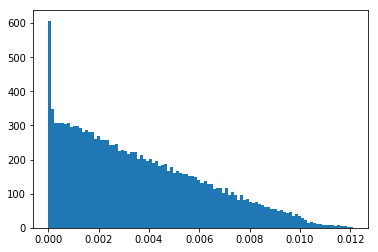

In [350]:
plt.hist(closest_highway, bins=100);

In [344]:
np.min(closest_highway)

2.0877020913382424e-07

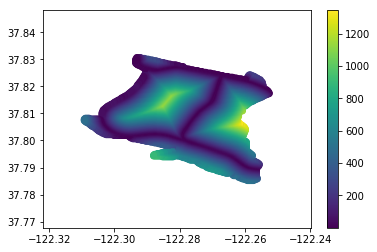

In [347]:
plt.scatter(training_grid.Long, training_grid.Lat, c=closest_highway*111111)
plt.colorbar()

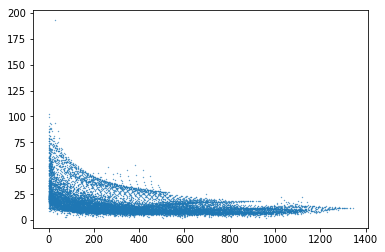

In [354]:
plt.scatter(closest_highway*111111, training_grid.NO_impute, s=0.1)

In [356]:
real_data = EDF_points['geometry'].apply(distance_to_highway, highways = highways)

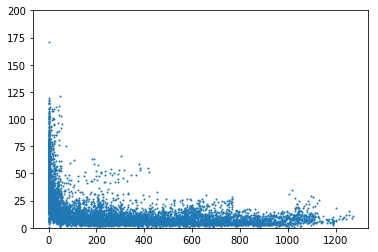

In [362]:
plt.scatter(real_data*111111, EDF_points['NO Value'], s=1)
plt.ylim(0, 200);

In [360]:
plt.scatter?

In [363]:
EDF_points.shape

(8035, 11)

In [364]:
GSV_df.shape

(21488, 6)